In [5]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

from TreeMazeAnalyses2.Analyses import subject_info as si
from TreeMazeAnalyses2.Analyses import cluster_match_functions as cmf

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [2]:
%%time
si = reload(si)
subjects = ['Cl']
overwrite = False
update_clusters = False
for subject in subjects:
    subject_info = si.SubjectInfo(subject, overwrite=overwrite)
    if update_clusters:
        subject_info.update_clusters()

CPU times: user 59.2 ms, sys: 8.48 ms, total: 67.6 ms
Wall time: 65.8 ms


In [3]:
%%time
si = reload(si)
overwrite=False
dm = subject_info.get_cluster_dists(overwrite=overwrite)

CPU times: user 38.2 ms, sys: 137 µs, total: 38.3 ms
Wall time: 40.9 ms


In [4]:
%%time
si = reload(si)
overwrite=True
cm  = subject_info.match_clusters(overwrite=overwrite, require_subsets=False)

CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 232 ms


In [16]:
cm[14]

{'analysis': (4,
  12.5,
  ['Cl_OF_112918',
   'Cl_T3g_112918',
   'Cl_T3g_113018',
   'Cl_OF_113018',
   'Cl_T3g_120118_0001',
   'Cl_OF_120118',
   'Cl_T3g_120318',
   'Cl_OF_120318'],
  32,
  [2, 3, 3, 6, 5, 3, 5, 5]),
 'matches_dict': {'Cl_OF_112918-tt4_d12.5_cl0': [set()],
  'Cl_T3g_112918-tt4_d12.5_cl9': [{'Cl_OF_112918-tt4_d12.5_cl9'}],
  'Cl_OF_112918-tt4_d12.5_cl9': [{'Cl_T3g_112918-tt4_d12.5_cl9'}],
  'Cl_OF_113018-tt4_d12.5_cl2': [{'Cl_T3g_112918-tt4_d12.5_cl1'}],
  'Cl_T3g_112918-tt4_d12.5_cl1': [{'Cl_OF_113018-tt4_d12.5_cl2'}],
  'Cl_T3g_112918-tt4_d12.5_cl4': [set()],
  'Cl_T3g_120118_0001-tt4_d12.5_cl2': [{'Cl_OF_120118-tt4_d12.5_cl1',
    'Cl_T3g_113018-tt4_d12.5_cl8'},
   {'Cl_OF_120118-tt4_d12.5_cl1', 'Cl_T3g_120318-tt4_d12.5_cl0'}],
  'Cl_T3g_113018-tt4_d12.5_cl8': [{'Cl_OF_120118-tt4_d12.5_cl1',
    'Cl_T3g_120118_0001-tt4_d12.5_cl2'}],
  'Cl_OF_120118-tt4_d12.5_cl1': [{'Cl_T3g_113018-tt4_d12.5_cl8',
    'Cl_T3g_120118_0001-tt4_d12.5_cl2'},
   {'Cl_T3g_120118_0001-t

In [24]:
cmf = reload(cmf)
def get_clusters_match_info(analysis_num):
    
    n_wf = 100
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    n_wf_samps = 128
    wf = np.zeros( (n_cl, n_wf, n_wf_samps))
    cl_info = pd.DataFrame(index=np.arange(n_cl), columns=['snr', 'fr', 'isi_viol', 'session', 'set_num','cl', 'session_cl_id'])
    cl_info['session_cl_id'] = dm[analysis_num]['cl_names']

    cl_cnt = 0

    for session_num, session in enumerate(sessions):
        cl_tt_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
        cl_idx = np.arange(n_cl_session[session_num])+cl_cnt

        wf[cl_idx] = subject_info.get_session_tt_wf(session, tt, cluster_ids=cl_tt_ids, n_wf=n_wf)

        cl_info.loc[cl_idx, 'snr'] = [subject_info.session_clusters[session]['clusters_snr'][tt][cl] for cl in cl_tt_ids]
        cl_info.loc[cl_idx, 'fr'] = [subject_info.session_clusters[session]['clusters_fr'][tt][cl] for cl in cl_tt_ids]
        cl_info.loc[cl_idx, 'isi_viol'] = [subject_info.session_clusters[session]['clusters_isi_viol_rate'][tt][cl] for cl in cl_tt_ids]

        cl_info.loc[cl_idx, 'session'] = session
        cl_info.loc[cl_idx, 'cl'] = np.array(cl_tt_ids).astype(int)

        cl_cnt += n_cl_session[session_num]

    for set_num, cl_set in enumerate(cm[analysis_num]['matches_sets']):
        cl_info.loc[cl_info.session_cl_id.isin(cl_set), 'set_num'] = set_num

    cl_info = cl_info.astype({'set_num': int})
    
    return wf, cl_info


def plot_cluster_match_sets(set_num):
    cl_set_info = cl_info[cl_info.set_num.isin([set_num])].copy() 
    
    cl_idx = cl_set_info.index
    cl_names = cl_set_info.session_cl_id.values
    
    wfm = np.median(wf[cl_idx], axis=1).T
    loc = [dm[analysis_num]['clusters_loc'][cl] for cl in cl_names]
    cov = [dm[analysis_num]['clusters_cov'][cl] for cl in cl_names]
    
    other_cl_set_info = cl_info[~cl_info.set_num.isin([set_num])].copy() 
    other_cl_names = other_cl_set_info.session_cl_id.values
    others_loc = [dm[analysis_num]['clusters_loc'][cl] for cl in other_cl_names]
    others_cov = [dm[analysis_num]['clusters_cov'][cl] for cl in other_cl_names]

    f, ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    ax[0].plot(wfm, linewidth=3)
    
    for jj in range(5):
        ax[0].axvline(32*jj, linestyle='--', color='0.2')
    
    ax[0].set_title("Waveforms")
    ax[0].set_ylabel(r"Amp [$\mu$V] ")
    
    aa=np.arange(0,129,32)
    ax[0].set_xticks(aa[:-1]+18)
    ax[0].set_xticklabels([f"ch{ch}" for ch in range(1,5)])
    
    cmf.plot_2d_cluster_ellipsoids(others_loc, others_cov, legend=False, cl_colors='grey', std_levels=[2], ax=ax[1])
    cmf.plot_2d_cluster_ellipsoids(loc, cov, cl_names=cl_names, legend=True, ax=ax[1])
    ax[1].set_title(" Clusters ")
    
    table_cols = ['snr', 'fr', 'isi_viol']
    ax[2].axis('off')
    ax[2].axis('tight')
    
    t = ax[2].table(cellText = cl_set_info[table_cols].values, colLabels=table_cols, 
                    rowColours = colors, colWidths=[0.1,0.3,0.3], loc='center')
    
    t.scale(1, 1.7)
    t.set_fontsize(14)
    t.auto_set_column_width(col=list(range(4)))
    
    
    sns.heatmap(dm[analysis_num]['dists_mats']['pe'].loc[cl_names,cl_names], annot=True, ax=ax[3])
    ax[3].set_title('PE distance')
    
    return f, ax


In [7]:
def see_how_many_clusters(analysis_num):
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    print(f" Analysis #{analysis_num}, tt {tt}, depth {d}")
    print(f" Number of sessions {len(sessions)}")
    print(f" Number of total clusters {n_cl}")
    print(f" Number of unique sets { len(cm[analysis_num]['matches_sets'])} ")
    return

interact(see_how_many_clusters,analysis_num=(0, len(dm)-1));

interactive(children=(IntSlider(value=27, description='analysis_num', max=54), Output()), _dom_classes=('widge…

## explore individual sets

In [10]:
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output

def analysis_str(analysis_num):
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    out_str = f"Analysis #{analysis_num}, tt {tt}, depth {d}\n" + \
              f" Number of sessions {len(sessions)}\n" + \
              f" Number of total clusters {n_cl}\n" + \
              f" Number of unique sets { len(cm[analysis_num]['matches_sets'])} \n"
    return out_str

def on_analysis_num_change(change):
    global wf
    global cl_info
    global analysis_num
    
    analysis_num = change.new
    with out:
        analysis_labels_w.value = analysis_str(analysis_num)
    
    wf, cl_info = get_clusters_match_info(analysis_num)
    set_num_w.options = range(len(cm[analysis_num]['matches_sets']))
    
def on_set_num_change(change):
    with out:
        clear_output()
        f, ax = plot_cluster_match_sets(change.new)
        show_inline_matplotlib_plots()
    #plt.show(f)

In [28]:
analysis_num = 0
wf, cl_info = get_clusters_match_info(analysis_num)

n_analyses = len(dm)
analysis_w = widgets.Dropdown(description='analysis_num', options=range(n_analyses), value=analysis_num)
set_num_w = widgets.Dropdown(description='set_num', options=range(len(cm[analysis_num]['matches_sets'])))
analysis_labels_w = widgets.Label(value = analysis_str(analysis_num) )

out = widgets.Output()    
analysis_w.observe(on_analysis_num_change, names='value')
set_num_w.observe(on_set_num_change, names='value')

display(analysis_w, set_num_w, analysis_labels_w, out)

Dropdown(description='analysis_num', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

Dropdown(description='set_num', options=(0, 1), value=0)

Label(value='Analysis #0, tt 1, depth 12.0\n Number of sessions 2\n Number of total clusters 2\n Number of uni…

Output()

In [27]:
n_units = 0 
n_unique_units = 0
for analysis_num in dm.keys():
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    n_units += n_cl
    n_unique_units += len(cm[analysis_num]['matches_sets'])

print(f"Total Units: {n_units}")
print(f"Total Unique: {n_unique_units}")

Total Units: 606
Total Unique: 384


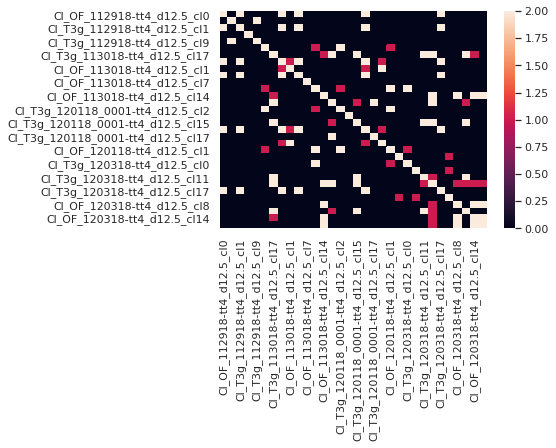

In [314]:
sns.heatmap( 1.0*(dm[14]['dists_mats']['he']<0.5)
            + (dm[14]['dists_mats']['pe']<0.5) )

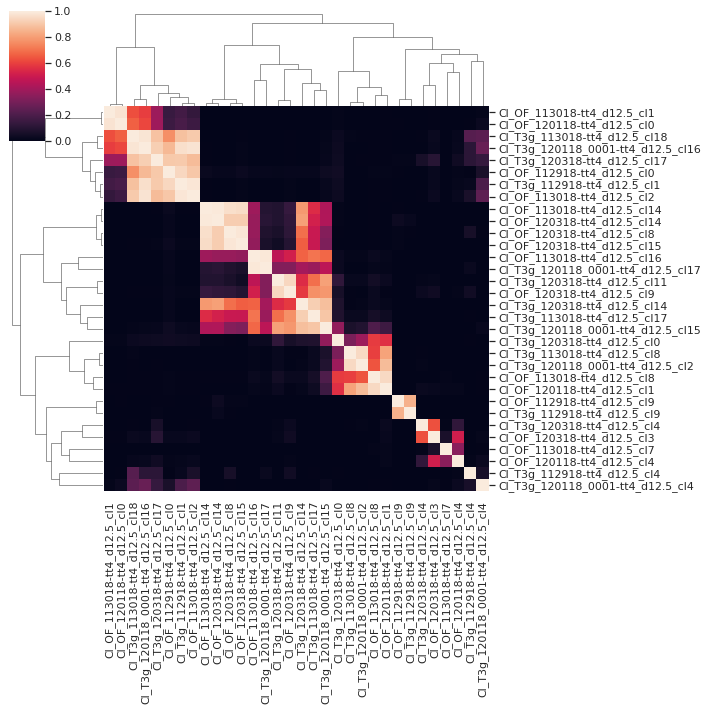

In [326]:
sns.clustermap(1-dm[14]['dists_mats']['pe']/dm[14]['dists_mats']['pe'].max())

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


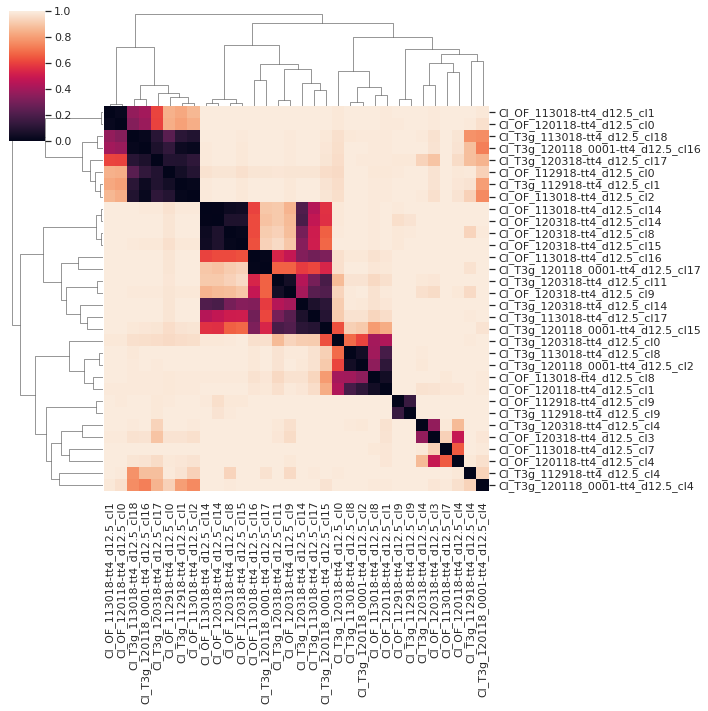

In [328]:
sns.clustermap(dm[14]['dists_mats']['pe'])